In [1]:
# Importing libraries
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [10]:
#Read Data
data = input_data.read_data_sets("MNIST/", one_hot=True)

Extracting MNIST/train-images-idx3-ubyte.gz
Extracting MNIST/train-labels-idx1-ubyte.gz
Extracting MNIST/t10k-images-idx3-ubyte.gz
Extracting MNIST/t10k-labels-idx1-ubyte.gz


In [3]:
samples = [[] for i in range(10)]
for image, label in zip(data.train.images, data.train.labels):
    label = np.argmax(label)
    if len(samples[label]) < 1000:
        samples[label].append(image / 255.5)
samples = [image for s in samples for image in s] # flatten

In [4]:
# Calculate distances between all samples
from scipy.spatial import distance_matrix
N = len(samples)
D_matrix = distance_matrix(samples, samples)
D_matrix = np.power(D_matrix, 2) # calculating the differences of square distances instead

In [20]:
tf.reset_default_graph()

# Placeholder for distance matrix
D = tf.placeholder(tf.float32, [N, N])

# Variable X' -> [10000, 2]
X_prime = tf.get_variable("X", initializer=tf.random_normal((N, 2), stddev=1.0))

# Calculate D' -> [10000, 10000]
#expanded_a = tf.expand_dims(X_prime, 1) # [10000, 1, 2]
#expanded_b = tf.expand_dims(X_prime, 0) # [1, 10000, 2]
#D_prime = tf.reduce_sum(tf.squared_difference(expanded_a, expanded_b), 2)

# Source: https://stackoverflow.com/questions/37009647/compute-pairwise-distance-in-a-batch-without-replicating-tensor-in-tensorflow
r = tf.reduce_sum(X_prime * X_prime, 1)
# turn r into column vector
r = tf.reshape(r, [-1, 1])
D_prime = r - 2*tf.matmul(X_prime, tf.transpose(X_prime)) + tf.transpose(r)

# Loss function
loss = tf.reduce_sum(tf.reduce_sum(tf.matrix_band_part(tf.pow(D_prime - D, 2), 0, -1)))

In [21]:
# Define optimizer
optim = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)

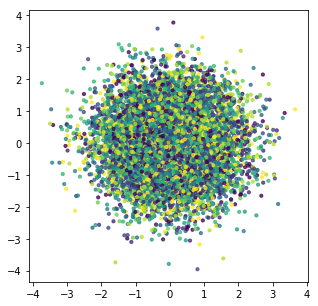

In [22]:
x = [x[0] for x in X]
y = [x[1] for x in X]
colors = [c for i in range(1000) for c in np.arange(0, 1, 0.1)]

plt.figure(figsize=(5, 5))
plt.scatter(x, y, s=10.0, c=colors, alpha=0.75)
plt.show()

In [24]:
from ipywidgets import FloatProgress
from IPython.display import display

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

# Make batches to train
num_iter = 1000
loss_values = []
progress = FloatProgress(min=0, max=num_iter); display(progress)
for i in range(num_iter):
    _, l, X = sess.run([optim, loss, X_prime], feed_dict = { D: D_matrix })
    loss_values.append(l)
    progress.value += 1
    progress.description = "Epoch %i/%i" % (i, num_iter)

plt.plot(loss_values)
plt.show()

ResourceExhaustedError: OOM when allocating tensor with shape[10000,10000] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](X/read, transpose)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: Sum_2/_13 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_293_Sum_2", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'MatMul', defined at:
  File "C:\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Anaconda3\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "C:\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Anaconda3\lib\site-packages\tornado\ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "C:\Anaconda3\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Anaconda3\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "C:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-d31f83d14913>", line 18, in <module>
    D_prime = r - 2*tf.matmul(X_prime, tf.transpose(X_prime)) + tf.transpose(r)
  File "C:\Anaconda3\lib\site-packages\tensorflow\python\ops\math_ops.py", line 2022, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "C:\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 2799, in _mat_mul
    name=name)
  File "C:\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3160, in create_op
    op_def=op_def)
  File "C:\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1625, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[10000,10000] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](X/read, transpose)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: Sum_2/_13 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_293_Sum_2", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [ ]:
x = [x[0] for x in X]
y = [x[1] for x in X]

plt.figure(figsize=(5, 5))
plt.scatter(x, y, s=10.0, c=colors)
plt.show()